In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
import re

In [67]:
data = pd.read_csv('e-GMAT_GMAT_Club_Reviews_Original.csv')

In [68]:
data.head()

,Page No,Date of Post,Review Heading,Username,Scores,Stars,Improvement,Course,Location,ReviewBody
0,1,27-Nov-24,e-GMAT Review,Sai01,Verified GMAT Focus score:\n675 Q87 V84 DI80 (...,stars stars5,70 Points,e-GMAT GMAT Live Prep,Online,Strengths:\n\n*Verbal Section\n*Data Analytics...
1,1,13-May-25,From 605 to 715– e-GMAT’s Last Mile Program & ...,Mayanksureka,Verified GMAT Focus score:\n665 Q84 V81 DI84,stars stars5,110 Points,e-GMAT Online Focused,Online,Strengths:\n\n1. Last Mile Program (LMP) & Men...
2,1,12-May-25,E-GMAT - Online 360 course (GMAT Focus Test),Shahshreyans007,Verified GMAT Focus score:\n695 Q87 V85 DI82,stars stars5,200 Points,e-GMAT Online 360,Online,Strengths:\n\n1. Adaptive preparation based on...
3,1,12-May-25,E-GMAT review,ChitwanM,Verified GMAT Focus score:\n725 Q90 V84 DI84,stars stars5,70 Points,e-GMAT Mentorship,Online,Strengths:\n\nTop-Notch Verbal Course (Especia...
4,1,09-May-25,Egmat review,avnitjha,Verified GMAT Focus score:\n725 Q88 V89 DI81,stars stars5,70 Points,e-GMAT GMAT Live Prep,Online,e-GMAT was a game-changer in my GMAT Focus pre...


# Helper Functions

In [69]:
# Format Review Display
def format_review(review):
    lines = review.split('\n')
    formated_review = []

    for line in lines:
        line = line.strip()
        if line.startswith('*'):
            line = '* ' + line[1:].strip()
        formated_review.append(line)
    return '\n'.join(formated_review)

# Format stars with number representation
def format_stars(star):
    stars_available = {'stars5': 5, 'stars4': 4, 'stars3': 3, 'stars2': 2, 'stars1': 1}
    return stars_available[star.split(' ')[-1]]

# Format Improvements
def points_improvement(points):
    point = int(str(points).split(' ')[0].strip())
    return point

# Format course names
def format_course(course):
    course = course.split('e-GMAT')[-1].strip()
    return course

### Clean the improved points data

In [70]:
data.rename(columns={'Improvement':'ImprovedPoints'}, inplace=True)
data['ImprovedPoints'].value_counts()

ImprovedPoints
70 Points     12
60 Points     11
40 Points     11
30 Points      9
120 Points     7
50 Points      7
100 Points     6
200 Points     5
110 Points     5
80 Points      5
90 Points      5
160 Points     3
130 Points     2
20 Points      2
150 Points     2
140 Points     1
10 Points      1
Name: count, dtype: int64

In [71]:
data['ImprovedPoints'] = data['ImprovedPoints'].fillna(0)
data['ImprovedPoints'].isna().sum()

0

In [72]:
data['ImprovedPoints'] = data['ImprovedPoints'].apply(points_improvement)

### Clean the review stars data

In [73]:
data['Stars'] = data['Stars'].apply(format_stars)

In [74]:
data['Stars'].value_counts()

Stars
5    98
4    11
1     1
Name: count, dtype: int64

### Clean course names

In [75]:
data['Course'] = data['Course'].apply(format_course)

### Create Year and Month columns

In [76]:
data.rename(columns={'Date of Post':'Date'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

C:\Users\yaamini\AppData\Local\Temp\ipykernel_21664\3189414833.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [77]:
data['Year'].value_counts()

Year
2024    60
2025    50
Name: count, dtype: int64

In [78]:
def rename_month(num):
    months = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
        7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }
    return months[num]
data['Month'] = data['Date'].dt.month.apply(rename_month)
data['Month'].value_counts()

Month
October      17
January      16
September    15
November     14
March        14
December     11
May           8
February      7
April         5
August        3
Name: count, dtype: int64

## Segment ReviewBody

In [79]:
# Separate Review segments
import spacy

nlp = spacy.load("en_core_web_sm")

def separate_review_segments(review):
    review = review.lower()
    doc = nlp(review.strip())
    extracted_segments = {
        'Strengths': [],
        'Improvements': [],
        'PersonalExperience': [],
        'Tips': [],
        'from': ''
    }
    
    current_section = None
    section_patterns = {
        'Strengths': ['strength', 'pro', 'advantage', 'excellent', 'changer', 'apart', 'great', 'liked', 'stands out'],
        'Improvements': ['improve', 'better', 'suggestion', 'enhance', 'however', 'while', 'the only'],
        'PersonalExperience': ['I', 'my', 'experience', 'journey', 'started', 'scored', 'scoring', 'appreciate', 'helped', 'me', 'improved'],
        'Tips': ['tip', 'recommend', 'advice', 'should', 'suggest', 'anyone']
    }

    if ':\n' in review:
        Strengths_text, improvements_text, experience_text, tips_text = '', '','',''
        text = review
        if 'tips for aspirants:' in text:
            start_index = text.find('tips for aspirants:') + len('tips for aspirants:')
            tips_text = text[start_index:].strip()  # Split off the personal experience section
            extracted_segments['Tips'].append(tips_text)
            text = text.split('tips for aspirants:')[0]
            
        if 'strengths:' in text:
            start_index = text.find('strengths:') + len('strengths:')
            Strengths_text = text[start_index:].split("would make the product better:")[0].strip()  # Split off the Improvements section
            extracted_segments['Strengths'].append(Strengths_text)
            text = text.split(Strengths_text)[-1]

        if 'would make the product better:' in text:
            start_index = text.find('would make the product better:') + len('would make the product better:\n')
            improvements_text = text[start_index:].split("\n\n")[0].strip()  # Split off the personal experience section
            extracted_segments['Improvements'].append(improvements_text)
            text = text.split(improvements_text)[-1]

        for section in extracted_segments:
            if len(extracted_segments[section]) < 1:
                if section == 'PersonalExperience' or section == 'from':
                    continue
                sentences = nlp(text).sents
                to_replace = []
                for sentence in sentences:
                    if any(keyword in sentence for keyword in section_patterns[section]):
                        extracted_segments[section].append(sentence)
                        to_replace.append(sentence)
                for sent in to_replace:
                    text = text.replace(sent, '')

        experience_text = text.strip()  # Split off the personal experience section
        extracted_segments['PersonalExperience'].append(experience_text)

        extracted_segments['from'] = 'headers'

        for section in extracted_segments:
            extracted_segments[section] = " ".join(extracted_segments[section]) if extracted_segments[section] else None
        return extracted_segments

    else:
        for sent in doc.sents:
            sent_text = sent.text.strip()
            sent_lower = sent_text.lower()
                        
            # NLP-based section detection
            if not current_section:
                for section, patterns in section_patterns.items():
                    if any(token.lemma_ in patterns for token in sent):
                        current_section = section
                        break
            
            if current_section:
                extracted_segments[current_section].append(sent_text)
        
    extracted_segments['from'] = 'conditional'

    for section in extracted_segments:
        extracted_segments[section] = " ".join(extracted_segments[section]) if extracted_segments[section] else None
    return extracted_segments


In [80]:
review_segments = pd.DataFrame(data['ReviewBody'].apply(separate_review_segments).tolist(), index = data.index)
data = pd.concat([data, review_segments], axis=1)
data.head()

,Page No,Date,Review Heading,Username,Scores,Stars,ImprovedPoints,Course,Location,ReviewBody,Year,Month,Strengths,Improvements,PersonalExperience,Tips,from
0,1,2024-11-27,e-GMAT Review,Sai01,Verified GMAT Focus score:\n675 Q87 V84 DI80 (...,5,70,GMAT Live Prep,Online,Strengths:\n\n*Verbal Section\n*Data Analytics...,2024,November,*verbal section\n*data analytics\n*price\n*liv...,*some typos on verbal questions should be addr...,i used e-gmat to improve my gmat score from 60...,None,h e a d e r s
1,1,2025-05-13,From 605 to 715– e-GMAT’s Last Mile Program & ...,Mayanksureka,Verified GMAT Focus score:\n665 Q84 V81 DI84,5,110,Online Focused,Online,Strengths:\n\n1. Last Mile Program (LMP) & Men...,2025,May,1. last mile program (lmp) & mentorship\nlmp a...,i had a good experience with e-gmat so far,i started my gmat journey at 605 and then scor...,1. be consistent—daily effort matters more tha...,h e a d e r s
2,1,2025-05-12,E-GMAT - Online 360 course (GMAT Focus Test),Shahshreyans007,Verified GMAT Focus score:\n695 Q87 V85 DI82,5,200,Online 360,Online,Strengths:\n\n1. Adaptive preparation based on...,2025,May,1. adaptive preparation based on your strength...,could increase the number of mock test papers ...,i had purchased e-gmat online 360. it had a ti...,None,h e a d e r s
3,1,2025-05-12,E-GMAT review,ChitwanM,Verified GMAT Focus score:\n725 Q90 V84 DI84,5,70,Mentorship,Online,Strengths:\n\nTop-Notch Verbal Course (Especia...,2025,May,top-notch verbal course (especially cr):\nthei...,a dynamic planner that adjusts based on weekly...,scoring a 725 on the gmat wouldn’t have been p...,None,h e a d e r s
4,1,2025-05-09,Egmat review,avnitjha,Verified GMAT Focus score:\n725 Q88 V89 DI81,5,70,GMAT Live Prep,Online,e-GMAT was a game-changer in my GMAT Focus pre...,2025,May,e-gmat was a game-changer in my gmat focus pre...,None,None,None,c o n d i t i o n a l


In [81]:
review_segments['from'].value_counts()

from
h e a d e r s            101
c o n d i t i o n a l      9
Name: count, dtype: int64

In [82]:
review_segments['Improvements'].isna().sum()

32

## Combine data to get commendations and suggestions

In [83]:
import spacy
import pandas as pd
from collections import defaultdict
from string import punctuation

nlp = spacy.load("en_core_web_lg")

positive_keywords = [
    "good", "great", "excellent", "helpful", "outstanding", "strong", 
    "best", "impressive", "beneficial", "reCommended", "liked", "love", 
    "improve", "effective", "convincing", "highly recommend", "praise", 
    "appreciate", "appreciated", "advantage", "outstanding", "remarkable", 
    "transformative", "satisfied", "valuable"
]

improvement_keywords = [
    "improve", "better", "suggestion", "enhance", "however", "could be better", 
    "recommend", "should be", "could improve", "problem", "issue", "recommendation",
    "needs", "would like", "suggest", "propose", "the only"
]

def summarize_row(text,type):
    doc = nlp(text)

    keywords = positive_keywords if type == 'commend' else improvement_keywords
    commendations = []
    
    # Iterate over sentences
    for sentence in doc.sents:
        # Check if any positive keyword is in the sentence
        if any(keyword in sentence.text.lower() for keyword in keywords):
            commendations.append(sentence.text.strip())
    
    # Combine commendations into a concise summary
    return " ".join(commendations)


In [84]:
data['Commended'] = data.apply(
    lambda row: summarize_row(' '.join(filter(None, [str(row['Strengths']), str(row['PersonalExperience'])])), 'commend')
    if row['from'] == 'conditional' else row['Strengths'],
    axis=1
)
# data['Commended'] = data[['Strengths','PersonalExperience']].fillna('').apply(' '.join, axis=1)
# combined = pd.DataFrame(data['Commended'].apply(lambda x: summarize_row(x, 'commend')), index = data.index)
# data['Commended'] = combined
data['Commended'] = data[['Course','Commended']].fillna('nil').apply(':\n'.join, axis=1)

data['Suggested'] = data.apply(
    lambda row: summarize_row(' '.join(filter(None, [str(row['Improvements']), str(row['PersonalExperience'])])), 'suggest')
    if row['from'] == 'conditional' else row['Improvements'],
    axis=1
)
# data['Suggested'] = data[['Improvements','PersonalExperience']].fillna('').apply(' '.join, axis=1)
# combined = pd.DataFrame(data['suggested'].apply(lambda x: summarize_row(x, 'suggest')), index = data.index)
# data['Suggested'] = combined
data['Suggested'] = data[['Course','Suggested']].fillna('nil').apply(':\n'.join, axis=1)

data.head()

,Page No,Date,Review Heading,Username,Scores,Stars,ImprovedPoints,Course,Location,ReviewBody,Year,Month,Strengths,Improvements,PersonalExperience,Tips,from,Commended,Suggested
0,1,2024-11-27,e-GMAT Review,Sai01,Verified GMAT Focus score:\n675 Q87 V84 DI80 (...,5,70,GMAT Live Prep,Online,Strengths:\n\n*Verbal Section\n*Data Analytics...,2024,November,*verbal section\n*data analytics\n*price\n*liv...,*some typos on verbal questions should be addr...,i used e-gmat to improve my gmat score from 60...,None,h e a d e r s,GMAT Live Prep:\n*verbal section\n*data analyt...,GMAT Live Prep:\n*some typos on verbal questio...
1,1,2025-05-13,From 605 to 715– e-GMAT’s Last Mile Program & ...,Mayanksureka,Verified GMAT Focus score:\n665 Q84 V81 DI84,5,110,Online Focused,Online,Strengths:\n\n1. Last Mile Program (LMP) & Men...,2025,May,1. last mile program (lmp) & mentorship\nlmp a...,i had a good experience with e-gmat so far,i started my gmat journey at 605 and then scor...,1. be consistent—daily effort matters more tha...,h e a d e r s,Online Focused:\n1. last mile program (lmp) & ...,Online Focused:\ni had a good experience with ...
2,1,2025-05-12,E-GMAT - Online 360 course (GMAT Focus Test),Shahshreyans007,Verified GMAT Focus score:\n695 Q87 V85 DI82,5,200,Online 360,Online,Strengths:\n\n1. Adaptive preparation based on...,2025,May,1. adaptive preparation based on your strength...,could increase the number of mock test papers ...,i had purchased e-gmat online 360. it had a ti...,None,h e a d e r s,Online 360:\n1. adaptive preparation based on ...,Online 360:\ncould increase the number of mock...
3,1,2025-05-12,E-GMAT review,ChitwanM,Verified GMAT Focus score:\n725 Q90 V84 DI84,5,70,Mentorship,Online,Strengths:\n\nTop-Notch Verbal Course (Especia...,2025,May,top-notch verbal course (especially cr):\nthei...,a dynamic planner that adjusts based on weekly...,scoring a 725 on the gmat wouldn’t have been p...,None,h e a d e r s,Mentorship:\ntop-notch verbal course (especial...,Mentorship:\na dynamic planner that adjusts ba...
4,1,2025-05-09,Egmat review,avnitjha,Verified GMAT Focus score:\n725 Q88 V89 DI81,5,70,GMAT Live Prep,Online,e-GMAT was a game-changer in my GMAT Focus pre...,2025,May,e-gmat was a game-changer in my gmat focus pre...,None,None,None,c o n d i t i o n a l,GMAT Live Prep:\ne-gmat was a game-changer in ...,GMAT Live Prep:\nnil


In [85]:
#### debug outputs
data.loc[55]['Commended']

"Online Focused:\ncontent and question bank\n\ni recently took the gmat (offline) and scored 685 (q88 v81 di83).\nself study phase : i utilized gmat club and gmatninja which got me till 645. however, i had hit a plateau at 645 and needed to identify gaps and fine tune my weaker areas.\nafter taking trial for most of the courses out there, i chose e-gmat because of the detailed and diverse categorization of topics and practice material on their platform.\n\nlmp : i was enrolled in the last mile push program, i worked closely with my mentor abha, who helped me with identifying the areas requiring a back-to-basics approach and those needing more practice.\nas a result, my accuracy improved significantly in verbal and di. in quant, we fine-tuned my problem-solving process for specific topics that were taking longer than average to solve.\n\noverall, i found e-gmat's content to be very carefully crafted, covering all aspects and question types you might encounter on the exam. the platform i

In [104]:
#### debug outputs
data.loc[55]['Suggested']

'Online 360:\ni feel the quant section needs to be re-evaluated.\nthe estimated course durations are not accurate.\nthe study plan set for me was far from realistic.'

In [87]:
#### debug outputs
review_segments.loc[50]['Strengths']

"content and question bank\n\ni recently took the gmat (offline) and scored 685 (q88 v81 di83).\nself study phase : i utilized gmat club and gmatninja which got me till 645. however, i had hit a plateau at 645 and needed to identify gaps and fine tune my weaker areas.\nafter taking trial for most of the courses out there, i chose e-gmat because of the detailed and diverse categorization of topics and practice material on their platform.\n\nlmp : i was enrolled in the last mile push program, i worked closely with my mentor abha, who helped me with identifying the areas requiring a back-to-basics approach and those needing more practice.\nas a result, my accuracy improved significantly in verbal and di. in quant, we fine-tuned my problem-solving process for specific topics that were taking longer than average to solve.\n\noverall, i found e-gmat's content to be very carefully crafted, covering all aspects and question types you might encounter on the exam. the platform is excellent, enab

In [88]:
#### debug outputs
review_segments.loc[50]['Improvements']

In [89]:
#### debug outputs
review_segments.loc[5]['PersonalExperience']

"i had been preparing for the gmat for quite some time on my own, but didn't have a structured method or proper understanding of the concepts that are actually tested on the gmat. after someone recommended e-gmat, i gave it a go and was immediately impressed with what they have been able to put together. the courses for all 3 sections are very well structured and emphasize on strengthening core concepts instead of just solving questions mindlessly. this changed the way i was looking at verbal reasoning and enabled me to consistently score v80+.\n\ni was mentored by rashmi in the last mile push (lmp) program, which is a customized plan for the last 4-5 weeks before the official exam. it was a great experience getting feedback from an experienced mentor about how to overcome some of the last-minute challenges and maintain consistency; and finally how to make sure you do your absolute best on the official exam.\n\nmy takeaway\n1. build trust in structured processes, own them and stick to 

In [91]:
#### debug outputs
print(format_review(data.loc[50]['ReviewBody']))

Strengths:

Content and Question Bank

I recently took the GMAT (offline) and scored 685 (Q88 V81 DI83).
Self Study phase : I utilized GMAT Club and GmatNinja which got me till 645. However, I had hit a plateau at 645 and needed to identify gaps and fine tune my weaker areas.
After taking trial for most of the courses out there, I chose e-Gmat because of the detailed and diverse categorization of topics and practice material on their platform.

LMP : I was enrolled in the Last Mile Push Program, I worked closely with my mentor Abha, who helped me with identifying the areas requiring a back-to-basics approach and those needing more practice.
As a result, My accuracy improved significantly in Verbal and DI. In Quant, we fine-tuned my problem-solving process for specific topics that were taking longer than average to solve.

Overall, I found e-GMAT's content to be very carefully crafted, covering all aspects and question types you might encounter on the exam. The platform is excellent, en

### Unique review contents and counts

In [92]:
data['Review Heading'].value_counts()

Review Heading
e-GMAT Review                                                                   3
E-GMAT review                                                                   2
e-GMAT Review: A Comprehensive GMAT Preparation Experience                      2
My GMAT Journey with e-GMAT                                                     2
A shot at consistency over uncertainty                                          1
                                                                               ..
Supremly structured customised course for all duration - 15 days to 4 months    1
Egmat focused edition                                                           1
Outstanding GMAT Prep Resource – e-GMAT!                                        1
Very well structured and Scientific Course                                      1
eGMAT - Course review                                                           1
Name: count, Length: 105, dtype: int64

In [93]:
data['Location'].value_counts()

Location
Online    110
Name: count, dtype: int64

In [94]:
data['Course'].value_counts()

Course
Online 360          46
Online Focused      44
Mentorship           8
Online Intensive     7
GMAT Live Prep       5
Name: count, dtype: int64

In [66]:
data.isnull().sum()

Page No                 0
Date of Post            0
Review Heading          0
Username                0
Scores                  2
Stars                   0
Improvement            16
Course                  0
Location                0
ReviewBody              0
Strengths              13
Improvements           32
PersonalExperience      5
Tips                  109
from                    0
Commended               0
Suggested               0
dtype: int64

## Save modified df

In [95]:
data.to_csv('e-GMAT_GMAT_Club_Reviews.csv')

## Visualization

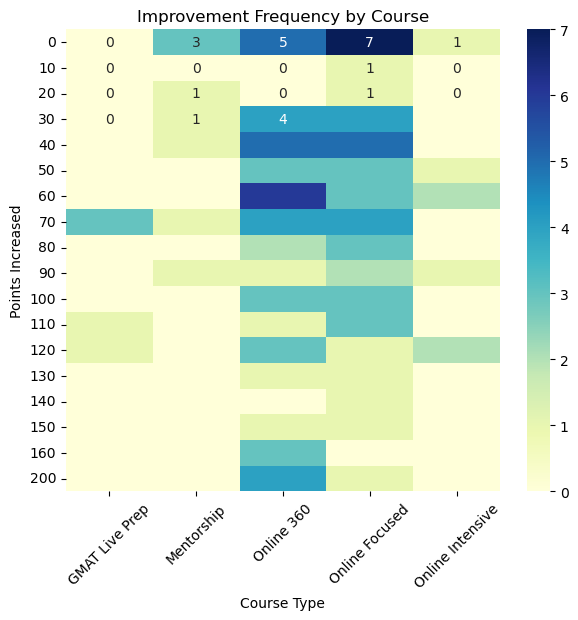

In [32]:
heatmap_data = pd.crosstab(data['ImprovedPoints'], course_data)

# Plot
plt.figure(figsize=(7, 6))
snb.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Improvement Frequency by Course')
plt.xlabel('Course Type')
plt.ylabel('Points Increased')
plt.xticks(rotation=45)
plt.show()

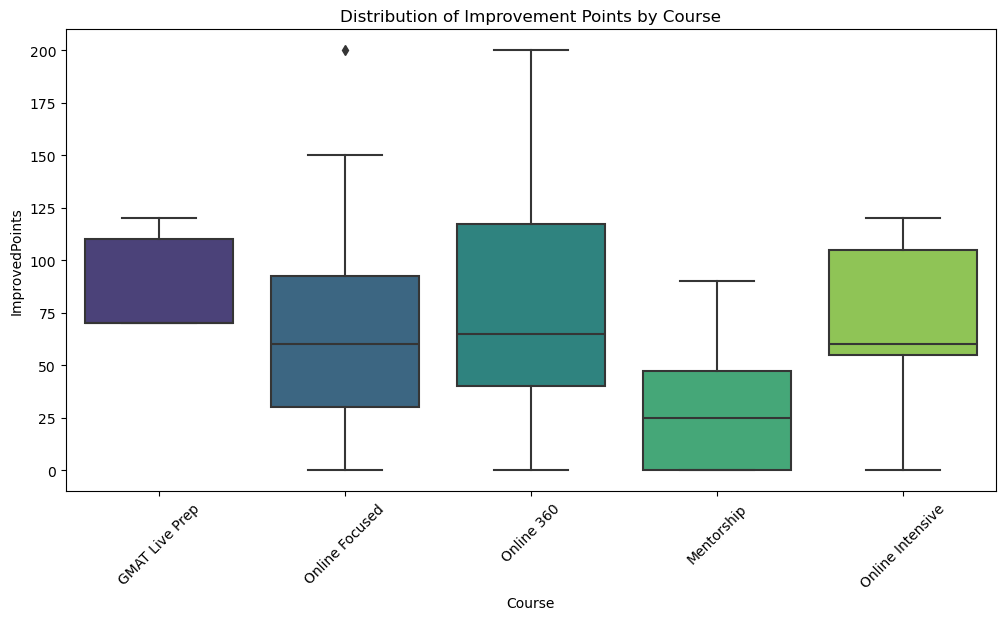

In [34]:
# Plot
plt.figure(figsize=(12, 6))
snb.boxplot(x='Course', y='ImprovedPoints', data=data, palette='viridis')
plt.title('Distribution of Improvement Points by Course')
plt.xticks(rotation=45)
plt.show()